# Same notebook as polarization.ipynb but rerun

# This new ML pipeline enables equal representation of each polarization state in each train, test, and validation dataset
### In the future, if needed, refactor into functions for efficiency

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [3]:
from core.getdata import *
from core.dataset import *
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288 # replicated

In [6]:
asd = DatasetPolar(ligands, polarization, replicas, size)

In [7]:
asd.labels.shape

(69552,)

In [8]:
m0 = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [9]:
print(len(m0), len(ib), len(ig), len(i0), len(i3), len(i4))

11592 11592 11592 11592 11592 11592


In [10]:
m0_train, m0_val, m0_test = torch.utils.data.random_split(m0, [6956, 2318, 2318])
ib_train, ib_val, ib_test = torch.utils.data.random_split(ib, [6956, 2318, 2318])
ig_train, ig_val, ig_test = torch.utils.data.random_split(ig, [6956, 2318, 2318])
i0_train, i0_val, i0_test = torch.utils.data.random_split(i0, [6956, 2318, 2318])
i3_train, i3_val, i3_test = torch.utils.data.random_split(i3, [6956, 2318, 2318])
i4_train, i4_val, i4_test = torch.utils.data.random_split(i4, [6956, 2318, 2318])

In [11]:
# extract all data and labels from each torch subset object and refactor into my own objects

def extract_xy(subsets):
    train, val, test = subsets # unpack tuple
    train_X = [item[0] for item in train]
    train_Y = [item[1] for item in train]
    val_X = [item[0] for item in val]
    val_Y = [item[1] for item in val]
    test_X = [item[0] for item in test]
    test_Y = [item[1] for item in test]
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [12]:
m0_train_X, m0_train_Y, m0_val_X, m0_val_Y, m0_test_X, m0_test_Y = extract_xy((m0_train, m0_val, m0_test))
ib_train_X, ib_train_Y, ib_val_X, ib_val_Y, ib_test_X, ib_test_Y = extract_xy((ib_train, ib_val, ib_test))
ig_train_X, ig_train_Y, ig_val_X, ig_val_Y, ig_test_X, ig_test_Y = extract_xy((ig_train, ig_val, ig_test))
i0_train_X, i0_train_Y, i0_val_X, i0_val_Y, i0_test_X, i0_test_Y = extract_xy((i0_train, i0_val, i0_test))
i3_train_X, i3_train_Y, i3_val_X, i3_val_Y, i3_test_X, i3_test_Y = extract_xy((i3_train, i3_val, i3_test))
i4_train_X, i4_train_Y, i4_val_X, i4_val_Y, i4_test_X, i4_test_Y = extract_xy((i4_train, i4_val, i4_test))

In [13]:
# split into 60/20/20 for each polarization dataset
# more empirical method to analyze model metrics across each polarization

# X = np.vstack([m0.data, ib.data, ig.data, i0.data, i3.data, i4.data])
# Y = np.hstack([m0.labels, ib.labels, ig.labels, i0.labels, i3.labels, i4.labels])

In [14]:
class TorchData:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [15]:
# need to concat all train_X and train_Y into one dataset for training
train_X = np.vstack([m0_train_X, ib_train_X, ig_train_X, i0_train_X, i3_train_X, i4_train_X])
train_Y = np.hstack([m0_train_Y, ib_train_Y, ig_train_Y, i0_train_Y, i3_train_Y, i4_train_Y])

val_X = np.vstack([m0_val_X, ib_val_X, ig_val_X, i0_val_X, i3_val_X, i4_val_X])
val_Y = np.hstack([m0_val_Y, ib_val_Y, ig_val_Y, i0_val_Y, i3_val_Y, i4_val_Y])

test_X = np.vstack([m0_test_X, ib_test_X, ig_test_X, i0_test_X, i3_test_X, i4_test_X])
test_Y = np.hstack([m0_test_Y, ib_test_Y, ig_test_Y, i0_test_Y, i3_test_Y, i4_test_Y])

In [16]:
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)
print(test_X.shape, test_Y.shape)

(41736, 98, 1) (41736,)
(13908, 98, 1) (13908,)
(13908, 98, 1) (13908,)


In [17]:
train = TorchData(train_X, train_Y)
val = TorchData(val_X, val_Y)
test = TorchData(test_X, test_Y)

In [18]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [19]:
# hyperparameters
input_size = 1
hidden_size = 98
output_size = 9

lr = 0.001
n_epochs = 70
batch_size = 64
device = torch.device('cuda')

In [20]:
net = LSTM(input_size=input_size, hidden_sizes=hidden_size, output_size=output_size, num_layers=3, device=device)

In [21]:
net.train()

LSTM(
  (lstm): LSTM(1, 98, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=98, out_features=9, bias=True)
)

In [22]:
trainer = LSTMTrainer(model=net, device=device)

In [23]:
trainer.train(trainloader, valloader, batch_size=batch_size, n_epochs=n_epochs)

  1%|█▏                                                                                 | 1/70 [00:09<10:21,  9.01s/it]

Epoch 001: | Training Loss: 2.1707462711319625 | Validation Loss: 2.2015839169878477


  3%|██▎                                                                                | 2/70 [00:16<09:15,  8.17s/it]

Epoch 002: | Training Loss: 2.17701458492834 | Validation Loss: 2.129789284609873


  4%|███▌                                                                               | 3/70 [00:24<08:49,  7.90s/it]

Epoch 003: | Training Loss: 2.1302770096894244 | Validation Loss: 2.126948178361315


  6%|████▋                                                                              | 4/70 [00:31<08:33,  7.77s/it]

Epoch 004: | Training Loss: 2.1277875770653556 | Validation Loss: 2.1647295011292904


  7%|█████▉                                                                             | 5/70 [00:39<08:21,  7.71s/it]

Epoch 005: | Training Loss: 2.084938475768015 | Validation Loss: 2.066047077332068


  9%|███████                                                                            | 6/70 [00:46<08:11,  7.69s/it]

Epoch 006: | Training Loss: 2.0564744936196764 | Validation Loss: 2.0306786233132037


 10%|████████▎                                                                          | 7/70 [00:54<08:02,  7.66s/it]

Epoch 007: | Training Loss: 1.9887534929453687 | Validation Loss: 1.8767763759018083


 11%|█████████▍                                                                         | 8/70 [01:02<07:54,  7.66s/it]

Epoch 008: | Training Loss: 1.835121721805146 | Validation Loss: 1.787023364403926


 13%|██████████▋                                                                        | 9/70 [01:09<07:47,  7.67s/it]

Epoch 009: | Training Loss: 1.7612904877976656 | Validation Loss: 1.6699126023765003


 14%|███████████▋                                                                      | 10/70 [01:17<07:40,  7.67s/it]

Epoch 010: | Training Loss: 1.6346002559749493 | Validation Loss: 1.622632985268164


 16%|████████████▉                                                                     | 11/70 [01:25<07:31,  7.65s/it]

Epoch 011: | Training Loss: 1.5684837570234242 | Validation Loss: 1.5449958963131687


 17%|██████████████                                                                    | 12/70 [01:32<07:23,  7.64s/it]

Epoch 012: | Training Loss: 1.5250014995907935 | Validation Loss: 1.5195913555425242


 19%|███████████████▏                                                                  | 13/70 [01:40<07:15,  7.64s/it]

Epoch 013: | Training Loss: 1.4811531057036489 | Validation Loss: 1.4636549938709364


 20%|████████████████▍                                                                 | 14/70 [01:48<07:07,  7.63s/it]

Epoch 014: | Training Loss: 1.430557507833332 | Validation Loss: 1.4273660850087437


 21%|█████████████████▌                                                                | 15/70 [01:55<06:59,  7.64s/it]

Epoch 015: | Training Loss: 1.4064488995129993 | Validation Loss: 1.38913112386651


 23%|██████████████████▋                                                               | 16/70 [02:03<06:52,  7.63s/it]

Epoch 016: | Training Loss: 1.35383919196326 | Validation Loss: 1.3626757318820428


 24%|███████████████████▉                                                              | 17/70 [02:11<06:44,  7.64s/it]

Epoch 017: | Training Loss: 1.3206061601273682 | Validation Loss: 1.32282798607415


 26%|█████████████████████                                                             | 18/70 [02:18<06:36,  7.63s/it]

Epoch 018: | Training Loss: 1.2868037305053488 | Validation Loss: 1.2957526445388794


 27%|██████████████████████▎                                                           | 19/70 [02:26<06:29,  7.64s/it]

Epoch 019: | Training Loss: 1.259538664386977 | Validation Loss: 1.2823610549126196


 29%|███████████████████████▍                                                          | 20/70 [02:33<06:21,  7.64s/it]

Epoch 020: | Training Loss: 1.2345127262528786 | Validation Loss: 1.264569048487812


 30%|████████████████████████▌                                                         | 21/70 [02:41<06:14,  7.64s/it]

Epoch 021: | Training Loss: 1.2118096200101773 | Validation Loss: 1.2322935002659439


 31%|█████████████████████████▊                                                        | 22/70 [02:49<06:06,  7.64s/it]

Epoch 022: | Training Loss: 1.1824731739155183 | Validation Loss: 1.2577694290821706


 33%|██████████████████████████▉                                                       | 23/70 [02:56<05:59,  7.64s/it]

Epoch 023: | Training Loss: 1.1659401839579047 | Validation Loss: 1.2289859696265755


 34%|████████████████████████████                                                      | 24/70 [03:04<05:51,  7.64s/it]

Epoch 024: | Training Loss: 1.1297685681039304 | Validation Loss: 1.213345057100331


 36%|█████████████████████████████▎                                                    | 25/70 [03:12<05:43,  7.64s/it]

Epoch 025: | Training Loss: 1.1192243367570465 | Validation Loss: 1.184512619851926


 37%|██████████████████████████████▍                                                   | 26/70 [03:19<05:37,  7.67s/it]

Epoch 026: | Training Loss: 1.0924619729266962 | Validation Loss: 1.1692534192986446


 39%|███████████████████████████████▋                                                  | 27/70 [03:27<05:29,  7.67s/it]

Epoch 027: | Training Loss: 1.0561761491879205 | Validation Loss: 1.157447463602101


 40%|████████████████████████████████▊                                                 | 28/70 [03:35<05:21,  7.66s/it]

Epoch 028: | Training Loss: 1.0280251059378818 | Validation Loss: 1.1360811749729542


 41%|█████████████████████████████████▉                                                | 29/70 [03:42<05:13,  7.66s/it]

Epoch 029: | Training Loss: 0.9991145059124069 | Validation Loss: 1.1401376639484266


 43%|███████████████████████████████████▏                                              | 30/70 [03:50<05:06,  7.66s/it]

Epoch 030: | Training Loss: 0.9766768623274646 | Validation Loss: 1.132417565638866


 44%|████████████████████████████████████▎                                             | 31/70 [03:58<04:58,  7.66s/it]

Epoch 031: | Training Loss: 0.9459900779800795 | Validation Loss: 1.100630589307995


 46%|█████████████████████████████████████▍                                            | 32/70 [04:05<04:50,  7.66s/it]

Epoch 032: | Training Loss: 0.9216041247293376 | Validation Loss: 1.0834310566066603


 47%|██████████████████████████████████████▋                                           | 33/70 [04:13<04:43,  7.67s/it]

Epoch 033: | Training Loss: 0.8817132025911468 | Validation Loss: 1.0844878218042742


 49%|███████████████████████████████████████▊                                          | 34/70 [04:21<04:36,  7.67s/it]

Epoch 034: | Training Loss: 0.8622426770365074 | Validation Loss: 1.061429150334192


 50%|█████████████████████████████████████████                                         | 35/70 [04:28<04:28,  7.67s/it]

Epoch 035: | Training Loss: 0.828438779478964 | Validation Loss: 1.0484603151268916


 51%|██████████████████████████████████████████▏                                       | 36/70 [04:36<04:20,  7.67s/it]

Epoch 036: | Training Loss: 0.798995165967284 | Validation Loss: 1.0567816676349815


 53%|███████████████████████████████████████████▎                                      | 37/70 [04:44<04:13,  7.67s/it]

Epoch 037: | Training Loss: 0.7858891680174911 | Validation Loss: 1.0345105843259654


 54%|████████████████████████████████████████████▌                                     | 38/70 [04:51<04:05,  7.66s/it]

Epoch 038: | Training Loss: 0.7511424004210082 | Validation Loss: 1.0400213055107572


 56%|█████████████████████████████████████████████▋                                    | 39/70 [04:59<03:57,  7.67s/it]

Epoch 039: | Training Loss: 0.71568304660857 | Validation Loss: 1.024537620467877


 57%|██████████████████████████████████████████████▊                                   | 40/70 [05:07<03:49,  7.66s/it]

Epoch 040: | Training Loss: 0.7080893362736812 | Validation Loss: 0.9956922591279406


 59%|████████████████████████████████████████████████                                  | 41/70 [05:14<03:42,  7.69s/it]

Epoch 041: | Training Loss: 0.6636553308591361 | Validation Loss: 0.9916605820896429


 60%|█████████████████████████████████████████████████▏                                | 42/70 [05:22<03:35,  7.69s/it]

Epoch 042: | Training Loss: 0.6452879016651312 | Validation Loss: 0.9914470397004294


 61%|██████████████████████████████████████████████████▎                               | 43/70 [05:30<03:27,  7.69s/it]

Epoch 043: | Training Loss: 0.6199713939912104 | Validation Loss: 0.9769996008194914


 63%|███████████████████████████████████████████████████▌                              | 44/70 [05:37<03:19,  7.69s/it]

Epoch 044: | Training Loss: 0.6152611505839215 | Validation Loss: 1.0065216394739414


 64%|████████████████████████████████████████████████████▋                             | 45/70 [05:45<03:12,  7.69s/it]

Epoch 045: | Training Loss: 0.5958730815289397 | Validation Loss: 0.9639853121490654


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [05:53<03:04,  7.70s/it]

Epoch 046: | Training Loss: 0.5559912365255093 | Validation Loss: 0.9698963285586156


 67%|███████████████████████████████████████████████████████                           | 47/70 [06:01<02:57,  7.70s/it]

Epoch 047: | Training Loss: 0.5440284394378136 | Validation Loss: 1.0106785315165825


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [06:08<02:49,  7.70s/it]

Epoch 048: | Training Loss: 0.5246494402381582 | Validation Loss: 0.9735584589866323


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [06:16<02:41,  7.70s/it]

Epoch 049: | Training Loss: 0.5111959420977471 | Validation Loss: 0.9507780848839961


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [06:24<02:34,  7.71s/it]

Epoch 050: | Training Loss: 0.48714480646080116 | Validation Loss: 0.9576605079917733


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [06:31<02:26,  7.71s/it]

Epoch 051: | Training Loss: 0.47887040973622436 | Validation Loss: 0.9732003328176814


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [06:39<02:18,  7.71s/it]

Epoch 052: | Training Loss: 0.481930269581618 | Validation Loss: 0.9712235237206888


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [06:47<02:11,  7.71s/it]

Epoch 053: | Training Loss: 0.43574607271877946 | Validation Loss: 0.9423886685196413


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [06:55<02:03,  7.71s/it]

Epoch 054: | Training Loss: 0.4248269282018974 | Validation Loss: 0.9583477053893815


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [07:02<01:55,  7.71s/it]

Epoch 055: | Training Loss: 0.46969018958702935 | Validation Loss: 0.968981315099865


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [07:10<01:47,  7.71s/it]

Epoch 056: | Training Loss: 0.3807449622413466 | Validation Loss: 0.9368656760235445


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [07:18<01:40,  7.71s/it]

Epoch 057: | Training Loss: 0.40194658642694653 | Validation Loss: 0.9774369887255747


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [07:25<01:32,  7.71s/it]

Epoch 058: | Training Loss: 0.384220894945252 | Validation Loss: 0.9631435718011419


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [07:33<01:24,  7.71s/it]

Epoch 059: | Training Loss: 0.368373000854555 | Validation Loss: 0.9822881559439756


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [07:41<01:17,  7.71s/it]

Epoch 060: | Training Loss: 0.34926845617078894 | Validation Loss: 0.9554423628323668


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [07:48<01:09,  7.71s/it]

Epoch 061: | Training Loss: 0.33658241052722493 | Validation Loss: 0.9839147699125316


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [07:56<01:01,  7.71s/it]

Epoch 062: | Training Loss: 0.3406491052091213 | Validation Loss: 0.951524962525849


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [08:04<00:53,  7.71s/it]

Epoch 063: | Training Loss: 0.3222346589950471 | Validation Loss: 0.9439387838228033


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [08:12<00:46,  7.71s/it]

Epoch 064: | Training Loss: 0.33963233036250107 | Validation Loss: 0.9584784548763835


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [08:19<00:38,  7.71s/it]

Epoch 065: | Training Loss: 0.2884971831125103 | Validation Loss: 0.9629036015873655


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [08:27<00:30,  7.71s/it]

Epoch 066: | Training Loss: 0.32983884493753335 | Validation Loss: 0.9903210110347206


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [08:35<00:23,  7.71s/it]

Epoch 067: | Training Loss: 0.28426089615862 | Validation Loss: 0.9723894354126869


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [08:43<00:15,  7.72s/it]

Epoch 068: | Training Loss: 0.26484723803323407 | Validation Loss: 0.9630472568470404


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [08:50<00:07,  7.72s/it]

Epoch 069: | Training Loss: 0.3027507654215804 | Validation Loss: 0.9458506465505022


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [08:58<00:00,  7.69s/it]

Epoch 070: | Training Loss: 0.2776476814316024 | Validation Loss: 0.9771806972289304


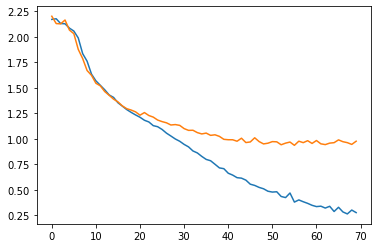

In [24]:
# visualize training/validation loss
plt.plot(trainer.loss_history[0])
plt.plot(trainer.loss_history[1])

# some forgetting, could rerun

In [25]:
# trainer.evaluate with testloader
prob, pred, true = trainer.evaluate(testloader)

In [26]:
from sklearn.metrics import classification_report

In [27]:
cr = classification_report(true, pred, target_names=ligands)

In [28]:
print(cr) # similar results to apeksha's model ~ 55% accuracy

              precision    recall  f1-score   support

         TNF       0.80      0.72      0.76      1569
         R84       0.82      0.84      0.83      1504
         PIC       0.82      0.84      0.83      1551
         P3K       0.76      0.77      0.77      1570
         FLA       0.68      0.68      0.68      1559
         CpG       0.71      0.69      0.70      1566
         FSL       0.68      0.72      0.70      1524
         LPS       0.73      0.72      0.73      1542
         UST       0.99      1.00      0.99      1523

    accuracy                           0.78     13908
   macro avg       0.78      0.78      0.78     13908
weighted avg       0.78      0.78      0.78     13908



In [29]:
fraction = Fraction(true, prob)

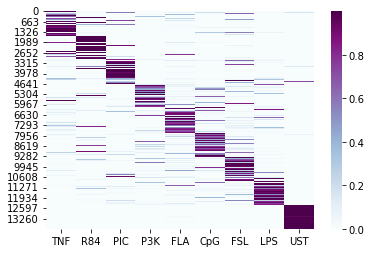

In [30]:
cf = sns.heatmap(fraction, cmap="BuPu", xticklabels=ligands)

## Polarization State Analysis

In [31]:
# refactor each polarization test_X and test_Y into torchdata object
# evaluate each one separately then concat and evaluate holistically

m0_test = TorchData(m0_test_X, m0_test_Y)
ib_test = TorchData(ib_test_X, ib_test_Y)
ig_test = TorchData(ig_test_X, ig_test_Y)
i0_test = TorchData(i0_test_X, i0_test_Y)
i3_test = TorchData(i3_test_X, i3_test_Y)
i4_test = TorchData(i4_test_X, i4_test_Y)

In [32]:
m0_loader = torch.utils.data.DataLoader(m0_test, batch_size=64, shuffle=True)
ib_loader = torch.utils.data.DataLoader(ib_test, batch_size=64, shuffle=True)
ig_loader = torch.utils.data.DataLoader(ig_test, batch_size=64, shuffle=True)
i0_loader = torch.utils.data.DataLoader(i0_test, batch_size=64, shuffle=True)
i3_loader = torch.utils.data.DataLoader(i3_test, batch_size=64, shuffle=True)
i4_loader = torch.utils.data.DataLoader(i4_test, batch_size=64, shuffle=True)

In [33]:
m0_prob, m0_pred, m0_true = trainer.evaluate(m0_loader)

In [34]:
ib_prob, ib_pred, ib_true = trainer.evaluate(ib_loader)

In [35]:
ig_prob, ig_pred, ig_true = trainer.evaluate(ig_loader)

In [36]:
i0_prob, i0_pred, i0_true = trainer.evaluate(i0_loader)

In [37]:
i3_prob, i3_pred, i3_true = trainer.evaluate(i3_loader)

In [38]:
i4_prob, i4_pred, i4_true = trainer.evaluate(i4_loader)

### M0

              precision    recall  f1-score      support
TNF            0.773438  0.764479  0.768932   259.000000
R84            0.782143  0.852140  0.815642   257.000000
PIC            0.817204  0.894118  0.853933   255.000000
P3K            0.662602  0.626923  0.644269   260.000000
FLA            0.598394  0.586614  0.592445   254.000000
CpG            0.557252  0.546816  0.551985   267.000000
FSL            0.567227  0.498155  0.530452   271.000000
LPS            0.648221  0.677686  0.662626   242.000000
UST            0.992157  1.000000  0.996063   253.000000
accuracy       0.713978  0.713978  0.713978     0.713978
macro avg      0.710960  0.716326  0.712927  2318.000000
weighted avg   0.709395  0.713978  0.710962  2318.000000


<AxesSubplot:>

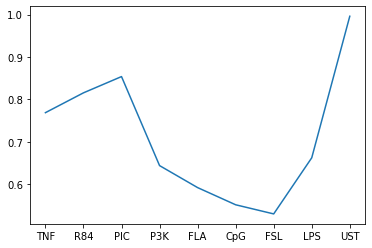

In [39]:
m0_cr = classification_report(m0_true, m0_pred, target_names=ligands, output_dict=True)
m0_crdf = pd.DataFrame(m0_cr).transpose()
print(m0_crdf)

m0_crdf[:9]['f1-score'].plot()

### ib

              precision    recall  f1-score      support
TNF            0.819512  0.608696  0.698545   276.000000
R84            0.846715  0.895753  0.870544   259.000000
PIC            0.789916  0.737255  0.762677   255.000000
P3K            0.818565  0.760784  0.788618   255.000000
FLA            0.734628  0.840741  0.784111   270.000000
CpG            0.739726  0.630350  0.680672   257.000000
FSL            0.675862  0.793522  0.729981   247.000000
LPS            0.720137  0.847390  0.778598   249.000000
UST            0.984190  0.996000  0.990060   250.000000
accuracy       0.788179  0.788179  0.788179     0.788179
macro avg      0.792139  0.790055  0.787090  2318.000000
weighted avg   0.792237  0.788179  0.786102  2318.000000


<AxesSubplot:>

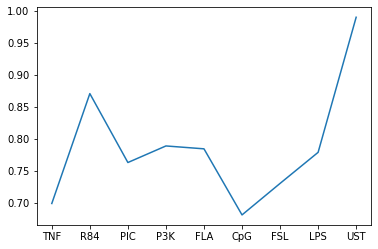

In [40]:
ib_cr = classification_report(ib_true, ib_pred, target_names=ligands, output_dict=True)
ib_crdf = pd.DataFrame(ib_cr).transpose()
print(ib_crdf)

ib_crdf[:9]['f1-score'].plot()

### ig

              precision    recall  f1-score      support
TNF            0.823256  0.643636  0.722449   275.000000
R84            0.796813  0.796813  0.796813   251.000000
PIC            0.807229  0.810484  0.808853   248.000000
P3K            0.633441  0.724265  0.675815   272.000000
FLA            0.563636  0.478764  0.517745   259.000000
CpG            0.556034  0.518072  0.536383   249.000000
FSL            0.520690  0.608871  0.561338   248.000000
LPS            0.546980  0.605948  0.574956   269.000000
UST            0.980159  1.000000  0.989980   247.000000
accuracy       0.685505  0.685505  0.685505     0.685505
macro avg      0.692026  0.687428  0.687148  2318.000000
weighted avg   0.690978  0.685505  0.685568  2318.000000


<AxesSubplot:>

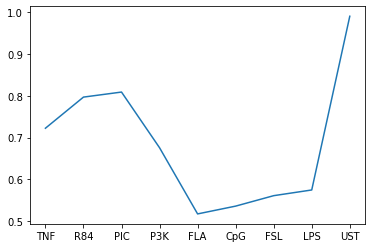

In [41]:
ig_cr = classification_report(ig_true, ig_pred, target_names=ligands, output_dict=True)
ig_crdf = pd.DataFrame(ig_cr).transpose()
print(ig_crdf)

ig_crdf[:9]['f1-score'].plot()

### i0

              precision    recall  f1-score      support
TNF            0.759657  0.686047  0.720978   258.000000
R84            0.780392  0.836134  0.807302   238.000000
PIC            0.829545  0.893878  0.860511   245.000000
P3K            0.807692  0.861940  0.833935   268.000000
FLA            0.660944  0.564103  0.608696   273.000000
CpG            0.779851  0.813230  0.796190   257.000000
FSL            0.716981  0.912000  0.802817   250.000000
LPS            0.805970  0.597786  0.686441   271.000000
UST            0.992308  1.000000  0.996139   258.000000
accuracy       0.792494  0.792494  0.792494     0.792494
macro avg      0.792593  0.796124  0.790334  2318.000000
weighted avg   0.792046  0.792494  0.788179  2318.000000


<AxesSubplot:>

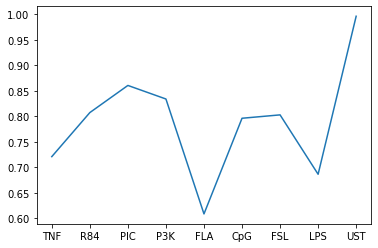

In [42]:
i0_cr = classification_report(i0_true, i0_pred, target_names=ligands, output_dict=True)
i0_crdf = pd.DataFrame(i0_cr).transpose()
print(i0_crdf)

i0_crdf[:9]['f1-score'].plot()

### i3

              precision    recall  f1-score      support
TNF            0.786517  0.840000  0.812379   250.000000
R84            0.897959  0.866142  0.881764   254.000000
PIC            0.857143  0.926471  0.890459   272.000000
P3K            0.837838  0.701887  0.763860   265.000000
FLA            0.730640  0.825095  0.775000   263.000000
CpG            0.762452  0.815574  0.788119   244.000000
FSL            0.764463  0.717054  0.740000   258.000000
LPS            0.837838  0.753036  0.793177   247.000000
UST            0.985075  0.996226  0.990619   265.000000
accuracy       0.827869  0.827869  0.827869     0.827869
macro avg      0.828880  0.826832  0.826153  2318.000000
weighted avg   0.829724  0.827869  0.827077  2318.000000


<AxesSubplot:>

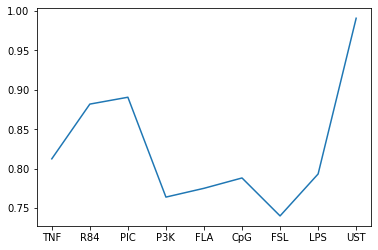

In [43]:
i3_cr = classification_report(i3_true, i3_pred, target_names=ligands, output_dict=True)
i3_crdf = pd.DataFrame(i3_cr).transpose()
print(i3_crdf)

i3_crdf[:9]['f1-score'].plot()

### i4

              precision    recall  f1-score      support
TNF            0.827869  0.804781  0.816162   251.000000
R84            0.850000  0.763265  0.804301   245.000000
PIC            0.794224  0.797101  0.795660   276.000000
P3K            0.839721  0.964000  0.897579   250.000000
FLA            0.762846  0.804167  0.782961   240.000000
CpG            0.824138  0.818493  0.821306   292.000000
FSL            0.852941  0.812000  0.831967   250.000000
LPS            0.879845  0.859848  0.869732   264.000000
UST            0.992032  0.996000  0.994012   250.000000
accuracy       0.845988  0.845988  0.845988     0.845988
macro avg      0.847068  0.846628  0.845964  2318.000000
weighted avg   0.846607  0.845988  0.845446  2318.000000


<AxesSubplot:>

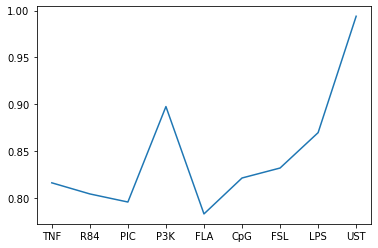

In [44]:
i4_cr = classification_report(i4_true, i4_pred, target_names=ligands, output_dict=True)
i4_crdf = pd.DataFrame(i4_cr).transpose()
print(i4_crdf)

i4_crdf[:9]['f1-score'].plot()

## Holistic

In [45]:
total_f1 = pd.concat([m0_crdf['f1-score'], ib_crdf['f1-score'], ig_crdf['f1-score'], i0_crdf['f1-score'], i3_crdf['f1-score'], i4_crdf['f1-score']], axis=1)
total_f1 = total_f1.set_axis(['M0', 'IB', 'IG', 'I0', 'I3', 'I4'], axis=1)

In [46]:
total_f1.iloc[:9]

,M0,IB,IG,I0,I3,I4
TNF,0.768932,0.698545,0.722449,0.720978,0.812379,0.816162
R84,0.815642,0.870544,0.796813,0.807302,0.881764,0.804301
PIC,0.853933,0.762677,0.808853,0.860511,0.890459,0.795660
P3K,0.644269,0.788618,0.675815,0.833935,0.763860,0.897579
FLA,0.592445,0.784111,0.517745,0.608696,0.775000,0.782961
CpG,0.551985,0.680672,0.536383,0.796190,0.788119,0.821306
FSL,0.530452,0.729981,0.561338,0.802817,0.740000,0.831967
LPS,0.662626,0.778598,0.574956,0.686441,0.793177,0.869732
UST,0.996063,0.990060,0.989980,0.996139,0.990619,0.994012


<AxesSubplot:>

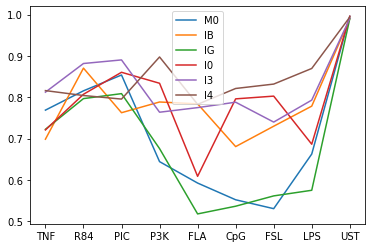

In [47]:
total_f1.iloc[:9].plot()

<AxesSubplot:>

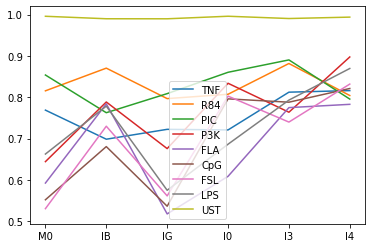

In [48]:
total_f1.iloc[:9].transpose().plot()

In [49]:
# average f1 score for all ligands across each polarization state
np.mean(total_f1.iloc[:9])

M0    0.712927
IB    0.787090
IG    0.687148
I0    0.790334
I3    0.826153
I4    0.845964
dtype: float64

<AxesSubplot:>

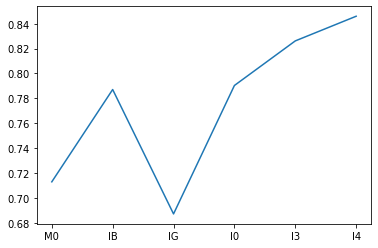

In [50]:
np.mean(total_f1.iloc[:9]).plot()